In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastai2.vision import *
from utils import *
import PIL

In [3]:
path = untar_data(URLs.PETS)

In [4]:
#path.ls()
files = get_image_files(path/'images')
files[0]

Path('/home/jayajasodani_gmail_com/.fastai/data/oxford-iiit-pet/images/Birman_61.jpg')

In [5]:
class ImageTuple(fastuple):   
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns)) #Converts two images into tuples  
    
    def show(self, ctx=None, **kwargs): #Converts tuples to tensors via if not isinstance(t1, Tensor)
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

In [47]:
img = ImageTuple.create((files[0], files[1]))   #to understand what each line in class ImageTuple does
img
#if not isinstance(img, Tensor): Tensor #alternativ 1 (fastai)
#Tensor
#img1 = Resize(224)(img)
#ten=ToTensor()(img1)                  #alternativ 2 (pytorch)
#show_image(ten[1])
tst = ToTensor()(img)
type(tst[0]),type(tst[1])

(fastai2.torch_core.TensorImage, fastai2.torch_core.TensorImage)

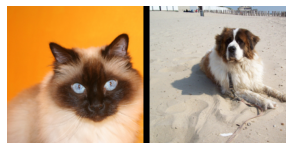

In [52]:
img1 = Resize(224)(img)
tst = ToTensor()(img1)
tst.show();

In [6]:
def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor) #A block is set of default transforms
#type_tfms defines image transform(resize img to 224 is applied later in DataBlock)
#batch_tfms needs FloatTensor to start image processing

In [84]:
ImageTupleBlock()

In [7]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

labels = list(set(files.map(label_func)))

lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

In [8]:
def draw_other(f):
    same = random.random() < 0.5
    cls = label_func(f)
    if not same: cls = random.choice(L(l for l in labels if l != cls)) 
    return random.choice(lbl2files[cls]),same

In [9]:
def get_tuple_files(path):
    files = get_image_files(path)
    return [[f, *draw_other(f)] for f in files]

In [10]:
#get_tuple_files(path/'images')

In [11]:
def get_x(t): return t[:2]
def get_y(t): return t[2]

In [74]:
get_x(ten[0][:2].shape) #ten[0] shape is [3,224]. where rows are height, width and color. Columns are different shades of color in the two height and width rows

torch.Size([2, 224])

In [75]:
get_x(ten[0][2].shape)

torch.Size([224, 224])

In [12]:
siamese = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock),
    get_items=get_tuple_files,
    get_x=get_x, get_y=get_y,
    splitter=RandomSplitter(),
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [13]:
dls = siamese.dataloaders(path/"images", path=path)

In [78]:
b = dls.one_batch()
explode_types(b)

{tuple: [{__main__.ImageTuple: [fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage]},
  fastai2.torch_core.TensorCategory]}

In [79]:
explode_types??

In [80]:
@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

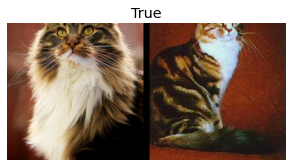

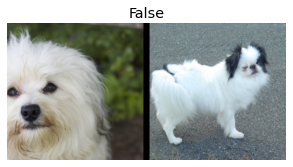

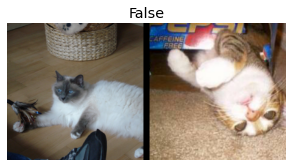

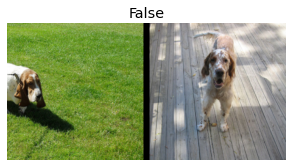

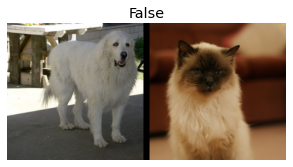

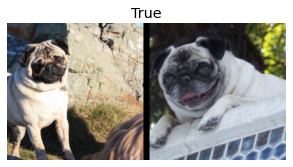

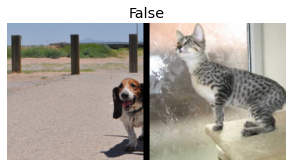

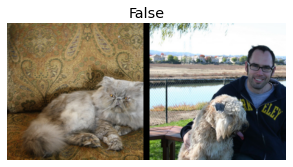

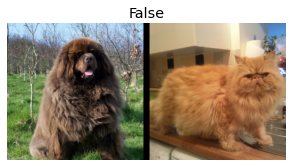

In [14]:
dls.show_batch() #Can b run without defining show_batch here. Default fastai fn.

In [ ]:
#Above program checks how show_batch() works. Test above and use it on own dataset.

In [ ]:
#Now we check how show_results() work

In [15]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [16]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai2.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [18]:
encoder = create_body(resnet34, cut=-2)

In [21]:
encoder[-3]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

In [22]:
head = create_head(512*4, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [68]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [23]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [26]:
#siamese_splitter(model)

In [25]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [28]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(t))
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(lbl2files[cls]),same

In [29]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

In [30]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [31]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy)

In [32]:
learn.freeze()

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=6.309573450380412e-07)

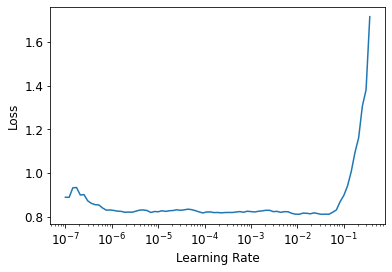

In [77]:
learn.lr_find()

In [78]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.525141,0.334569,0.857916,02:56
1,0.363883,0.211874,0.924222,02:55
2,0.300245,0.169977,0.941813,02:55
3,0.250194,0.153175,0.952639,02:55


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(4, slice(1e-6,1e-4))

In [79]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

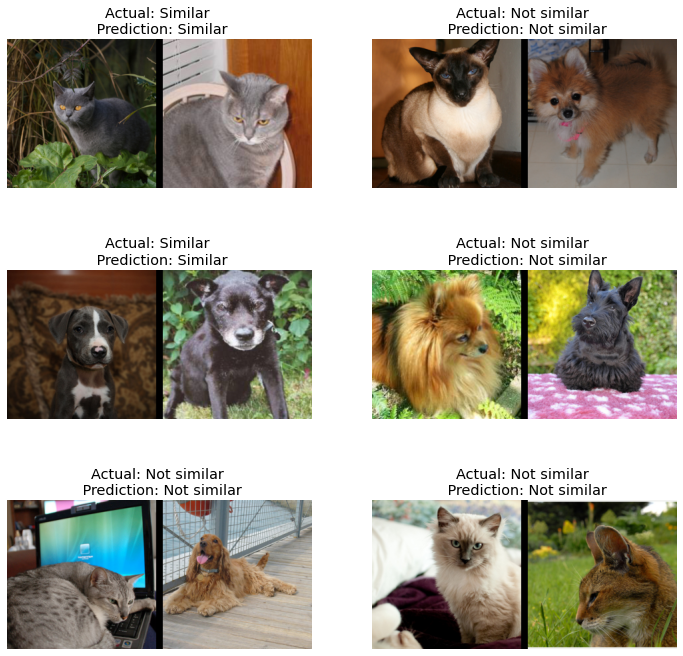

In [80]:
learn.show_results()

In [47]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    print(res)
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

In [48]:
imgtest = PILImage.create(files[0])
imgval = PILImage.create(files[100])
siamtest = SiameseImage(imgval, imgtest)
#siamtest.show();

(tensor(1), tensor(1), tensor([0.3634, 0.6366])) tensor(1) tensor(1) tensor([0.3634, 0.6366])


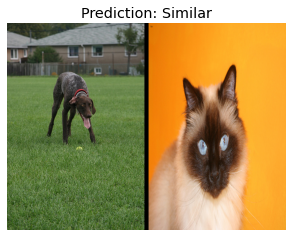

In [49]:
res = learn.siampredict(siamtest)